# Wassersein distance maps
26th September 2024

Using independent BCMs to model the mean and variance and empirical Wasserstein distance.

In [2]:
import glob
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from shapely.geometry import LinearRing
import matplotlib.patheffects as pe

import sys
sys.path.append(
    '/Users/kenzatazi/Documents/CDT/Code/')
from load import aphrodite, data_dir
from cartopy.io import shapereader


In [3]:
files = glob.glob('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/weights/wass_historical_*1951_2005.csv')
files.sort(key=str.casefold)
files

['/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/weights/wass_historical_CanESM2_RegCM4_1951_2005.csv',
 '/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/weights/wass_historical_CNRM_RCA4_1951_2005.csv',
 '/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/weights/wass_historical_CNRM_RegCM4_1951_2005.csv',
 '/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/weights/wass_historical_CSIRO_RegCM4_1951_2005.csv',
 '/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/weights/wass_historical_ECEARTH_RCA4_1951_2005.csv',
 '/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/weights/wass_historical_GFDL_RCA4_1951_2005.csv',
 '/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/weights/wass_historical_GFDL_RegCM4_1951_2005.csv',
 '/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/weights/wass_historical_IPSL_RCA4_1951_2005.csv',
 '/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/weights/wass_historical_IPSL_RegCM4_1951_2005.csv',
 '/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/weights/wass_historical

In [4]:
# pass the wassertein distance to softmax function

df_list = []
model_names = []

for file in files:
    df = pd.read_csv(file)
    ref = file.split('_')[-4:]
    name = ref[0] + ' ' + ref[1]
    model_names.append(name)
    df.attrs['ref'] = name
    df_list.append(df)

In [5]:
model_names[4] = 'EC-Earth RCA4'

In [6]:
wass_list = []

for df in df_list:
    df1 = df.set_index(['month', 'lon', 'lat',])
    ds = xr.Dataset.from_dataframe(df1)
    ds = ds.interpolate_na(dim='lat', method='linear', limit=5)
    wass_list.append(ds.wass.values)

In [7]:
wass = np.array(wass_list)

In [8]:
wass.shape # rcm x month x lon x lat x 1

(13, 12, 180, 80)

## Best RCM 

In [9]:
# for each lat, lon and month choose the rcm with the smallest wass distance
# plot with xarray for lat and lon

wass_min = np.min(wass, axis=0) # month x lon x lat x 1 

# also locate the index of the minimum wass distance
wass_min_idx = np.argmin(wass, axis=0) # month x lon x lat x 1

In [10]:
wass_min_idx.squeeze().shape

(12, 180, 80)

In [11]:
# convert the np.array to xarray
wass_min_xr = xr.DataArray(wass_min_idx.squeeze(), dims=['month', 'lon', 'lat'], coords=[np.arange(1,13), np.arange(60.125, 105, 0.25), np.arange(20.125, 40, 0.25)])

In [12]:
#model_names = ['CSIRO-RegCM4', 'MIROC-RCA4', 'MPI-RegCM4', 'MPI-REMO2009', 'GFDL-RCA4']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [13]:
from matplotlib.colors import LinearSegmentedColormap

In [14]:
def regional_rectangle(lonmin, lonmax, latmin, latmax, nvert=100):
    """ Return Polygon object to create regional rectangle on maps."""
    lons = np.r_[
        np.linspace(lonmin, lonmin, nvert),
        np.linspace(lonmin, lonmax, nvert),
        np.linspace(lonmax, lonmax, nvert),
    ].tolist()

    lats = np.r_[
        np.linspace(latmin, latmax, nvert),
        np.linspace(latmax, latmax, nvert),
        np.linspace(latmax, latmin, nvert),
    ].tolist()

    pgon = LinearRing(list(zip(lons, lats)))

    return pgon

In [15]:
# HKH region
hkh_region_path = data_dir + "Shapefiles/hkh/outline.shp"
hkh_region_shape = shapereader.Reader(hkh_region_path)
hkh_region_globe = ccrs.Globe(semimajor_axis=6377276.345, inverse_flattening=300.8017)
hkh_region = ccrs.PlateCarree()

In [16]:
hma1 = regional_rectangle(71, 79, 32, 39)
hma2 = regional_rectangle(76, 93, 27, 32)
hma3 = regional_rectangle(93, 103, 28, 36)
region_dict2 = {'HMA1': [71.5, 37.5], 'HMA2': [76.5, 30.5], 'HMA3': [93.5, 34.5],}   

In [17]:
colorlist_hex = [ '#bcbd22', '#a6cee3', '#2078b4', '#16becf', '#c49c94', '#b2df8a', '#32a02d', '#ff9896', '#d62728', '#f0d7fa', '#fdbf6f', 
                 '#fd8d3c', '#ed671c']
proj = ccrs.PlateCarree()

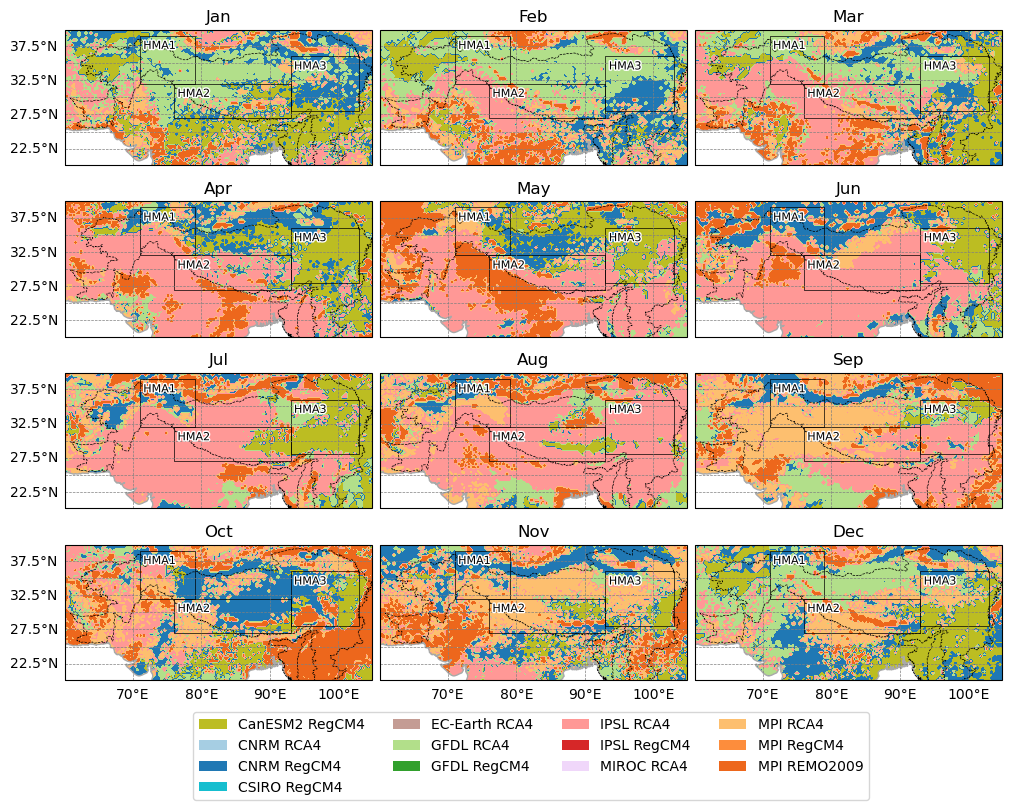

In [33]:
# For each month, plot make a plot where the color of each lat lon is the rcm with the smallest wass distance

fig, ax = plt.subplots(4, 3, figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()}, layout="constrained")

ocean_50m = cf.NaturalEarthFeature("physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

cmap = LinearSegmentedColormap.from_list('mycmap', colorlist_hex, N=13)

#'Paired', 12)

for i in range(12):
    wass_min_xr.sel(month=i+1).plot.contourf(x='lon', y='lat', ax=ax[i//3, i%3], cmap=cmap, zorder=-10, 
                                             add_colorbar=False)
    ax[i//3, i%3].set_title(months[i])
    gl = ax[i//3, i%3].gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False
    if i % 3 != 0:
       gl.left_labels = False
    if i // 3 != 3:
        gl.bottom_labels = False
    ax[i//3, i%3].add_feature(ocean_50m, zorder=-9)
    ax[i//3, i%3].add_geometries([hma1, hma2, hma3], proj, edgecolor="black",
            facecolor="None", linestyle='-', linewidth=0.5)
    for region, coord in region_dict2.items():
        ax[i//3, i%3].text(coord[0], coord[1], region, fontsize=8, color='black', ha='left', va='center', zorder=10, 
            path_effects=[pe.withStroke(linewidth=2, foreground="white")]) 
    for rec in hkh_region_shape.records():
        ax[i//3, i%3].add_geometries(
            [rec.geometry],
            hkh_region,
            edgecolor="black",
            facecolor="None",
            linestyle='--',
            linewidth=0.5,
            zorder=-8)
labels = model_names
handles = [Patch(facecolor=colorlist_hex[i]) for i in range(13)]
fig.legend(handles, labels, ncol=4, bbox_to_anchor=(0.87, 0))

# Rasterize negative zorder
for a in ax.flat:
    a.set_rasterization_zorder(0)

plt.savefig('best_rcm_13.pdf', dpi=300, bbox_inches='tight')

### Agreement of models

In [127]:
wass_var = np.var(wass, axis=0) # month x lon x lat x 1

In [128]:
wass_var_xr = xr.DataArray(wass_var.squeeze(), dims=['month', 'lon', 'lat'], coords=[np.arange(1,13), np.arange(60.125, 105, 0.25), np.arange(20.125, 40, 0.25)])

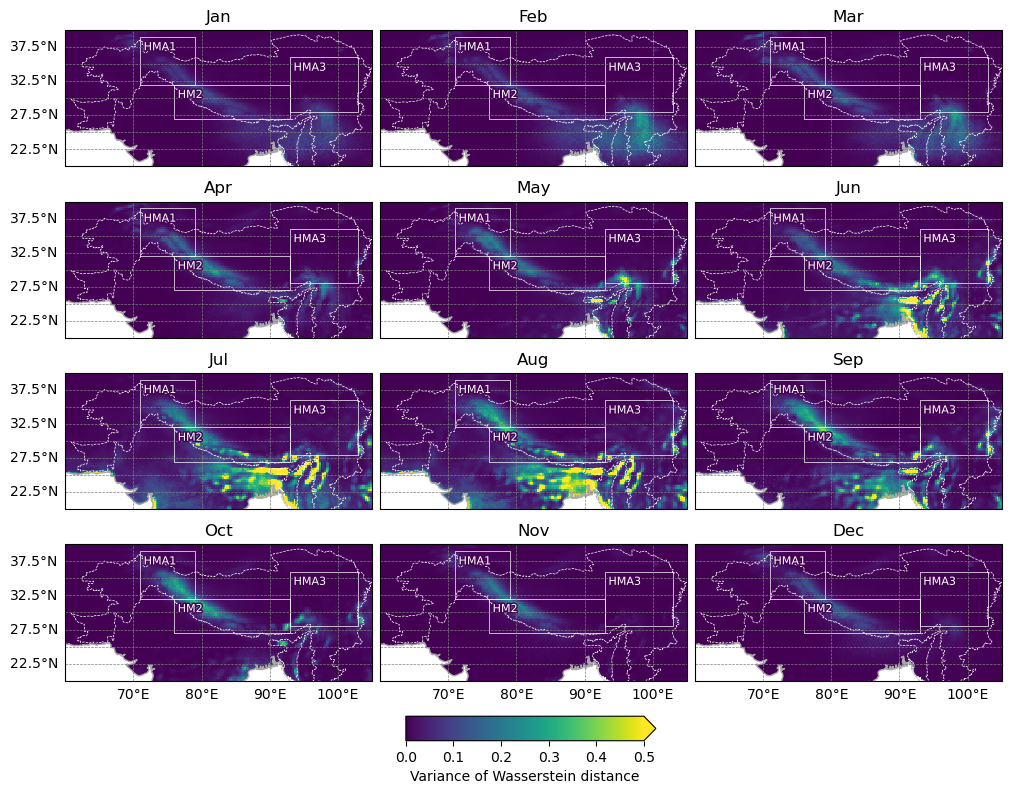

In [133]:
# For each month, plot make a plot where the color of each lat lon is the rcm with the smallest wass distance

fig, ax = plt.subplots(4, 3, figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()}, layout="constrained")

ocean_50m = cf.NaturalEarthFeature(
        "physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

for i in range(12):
    g = wass_var_xr.sel(month=i+1).plot(x='lon', y='lat', ax=ax[i//3, i%3], cmap='viridis', vmin=0, vmax=0.5,
                                         add_colorbar=False, linewidth=0,rasterized=True)
    ax[i//3, i%3].set_title(months[i])
    gl = ax[i//3, i%3].gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False
    if i % 3 != 0:
       gl.left_labels = False
    if i // 3 != 3:
        gl.bottom_labels = False
    ax[i//3, i%3].add_feature(ocean_50m)
    ax[i//3, i%3].add_geometries([hma1, hma2, hma3], proj, edgecolor="white",
            facecolor="None", linestyle='-', linewidth=0.5)
    for region, coord in region_dict2.items():
        ax[i//3, i%3].text(coord[0], coord[1], region, fontsize=8, color='white', ha='left', va='center', zorder=10,
            path_effects=[pe.withStroke(linewidth=2, foreground="#440154")])
        # HKH boundaries
    for rec in hkh_region_shape.records():
        ax[i//3, i%3].add_geometries(
            [rec.geometry],
            hkh_region,
            edgecolor="white",
            facecolor="None",
            linestyle='--',
            linewidth=0.5)


cax = fig.add_axes([0.4, -0.05, 0.25, 0.035])
fig.colorbar(g, cax=cax, orientation='horizontal', label='Variance of Wasserstein distance', extend='max')

plt.savefig('rcm_agreement.pdf', bbox_inches='tight')

## Joint seasonal plot (not used)

In [56]:
import sys
sys.path.append('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/')
from utils import areal_plots

In [57]:
wass = np.array(wass_list)
wass_ds = xr.Dataset({'wass': (['model', 'month', 'lon', 'lat'], wass)}, coords={'model': model_names, 'month': np.arange(1, 13), 'lon': np.arange(60.125, 105, 0.25), 'lat': np.arange(20.125, 40, 0.25)})

In [58]:
ds_jun = wass_ds.isel(month=5)
ds_jul = wass_ds.isel(month=6)
ds_aug = wass_ds.isel(month=7)
ds_sep = wass_ds.isel(month=8)
ds_monsoon = xr.concat([ds_jun, ds_jul, ds_aug, ds_sep], dim='month')
ds_monsoon_avg = ds_monsoon['wass'].mean(dim='month')

ds_dec = wass_ds.isel(month=11)
ds_jan = wass_ds.isel(month=0)
ds_feb = wass_ds.isel(month=1)
ds_mar = wass_ds.isel(month=2)
ds_west =  xr.concat([ds_dec, ds_jan, ds_feb, ds_mar], dim='month')
ds_west_avg = ds_west['wass'].mean(dim='month')

In [59]:
wass_moonsoon_min_idx = np.argmin(ds_monsoon_avg.values, axis=0)
wass_west_min_idx = np.argmin(ds_west_avg.values, axis=0)

In [60]:
wass_monsoon_xr = xr.DataArray(wass_moonsoon_min_idx.squeeze(), dims=['lon', 'lat'], coords=[ np.arange(60.125, 105, 0.25), np.arange(20.125, 40, 0.25)])
wass_west_xr = xr.DataArray(wass_west_min_idx.squeeze(), dims=['lon', 'lat'], coords=[ np.arange(60.125, 105, 0.25), np.arange(20.125, 40, 0.25)])

In [61]:
wass_monsoon_ds = xr.Dataset({'wass': wass_monsoon_xr})
wass_west_ds = xr.Dataset({'wass': wass_west_xr})

In [62]:
wass_monsoon_ds['var'] = ds_monsoon_avg.var(dim='model')
wass_west_ds['var'] = ds_west_avg.var(dim='model')

In [63]:
wass_west_xr

<xarray.DataArray (lon: 180, lat: 80)>
array([[ 7,  7,  7, ...,  5,  4,  5],
       [ 7,  7, 10, ...,  4,  5,  4],
       [ 7,  7,  7, ...,  4,  4,  4],
       ...,
       [ 3,  3,  3, ...,  1,  1,  1],
       [ 3,  3,  3, ...,  1,  1,  4],
       [ 3,  3,  3, ...,  1,  1,  1]])
Coordinates:
  * lon      (lon) float64 60.12 60.38 60.62 60.88 ... 104.1 104.4 104.6 104.9
  * lat      (lat) float64 20.12 20.38 20.62 20.88 ... 39.12 39.38 39.62 39.88

In [64]:
# build a rectangle in axes coords
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

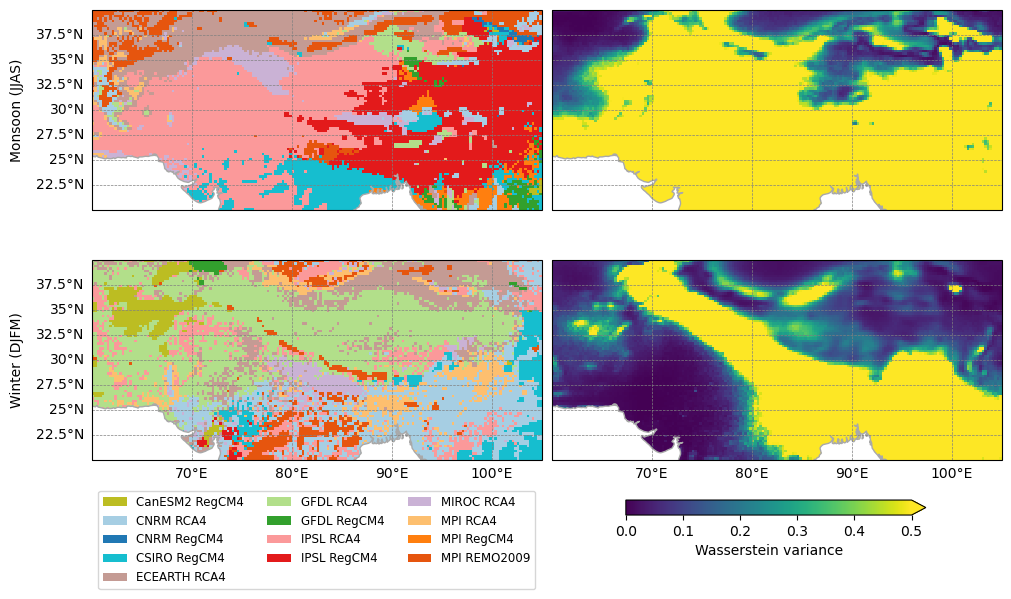

In [65]:
# For each season, plot make a plot where the color of each lat lon is the rcm with the smallest wass distance

ocean_50m = cf.NaturalEarthFeature(
        "physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')
cmap = LinearSegmentedColormap.from_list('mycmap', colorlist_hex, N=13)
proj = ccrs.PlateCarree()
#ds_avg_ypred = xr.concat([wass_monsoon_ds, wass_west_ds], pd.Index(["Monsoon (DJFM)", "Winter (DJFM)"], name='scenario'))

fig, ax = plt.subplots(2, 2, figsize=(10,5), sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
#fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

wass_monsoon_ds.wass.plot(x="lon", y="lat", ax=ax[0, 0], cmap=cmap, add_colorbar=False)
wass_west_ds.wass.plot(x="lon", y="lat", ax=ax[1, 0], cmap=cmap, add_colorbar=False)
wass_monsoon_ds['var'].plot(x="lon", y="lat", ax=ax[0, 1], cmap='viridis', add_colorbar=False, vmin=0, vmax=0.5)
var_fg = wass_west_ds['var'].plot(x="lon", y="lat", ax=ax[1, 1], cmap='viridis', add_colorbar=False, vmin=0, vmax=0.5)


# add legend axis
labels = model_names
handles = [Patch(facecolor=colorlist_hex[i]) for i in range(13)]
fig.legend(handles, labels, bbox_to_anchor=(0.535,0), ncol=3, prop={'size': 8.5})

# add colorbar axis
cax= fig.add_axes([0.62, -0.06, 0.3, 0.03])
cbar = plt.colorbar(var_fg, cax=cax, orientation='horizontal', label='Wasserstein variance', extend='max')
cbar.ax.tick_params(labelsize=10)

for axs in ax.flat:
    gl = axs.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False
    axs.add_feature(ocean_50m)

    if axs == ax[0, 0]:
        gl.bottom_labels = False
    if axs == ax[0, 1]:
        gl.bottom_labels = False
        gl.left_labels = False
    if axs == ax[1, 0]:
        pass
    if axs == ax[1, 1]:
        gl.left_labels = False

ax[0, 0].text(left-0.4, 0.5*(bottom+top), "Monsoon (JJAS)",
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        transform=ax[0,0].transAxes)

ax[1, 0].text(left-0.4, 0.5*(bottom+top), "Winter (DJFM)",
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        transform=ax[1,0].transAxes)
        
plt.savefig('wass_where.pdf', bbox_inches='tight')

## Weight map

In [20]:
weight_arr = np.load('../../data/weights/250110_weights_beta_p95_for_wass_no_p95_for_dist_5x5.npy')

In [21]:
weight_arr.shape

(13, 12, 180, 80)

In [22]:
max_w_arr = np.max(weight_arr, axis=0)

In [23]:
cbar_max = np.nanmax(max_w_arr)
cbar_min = np.nanmin(max_w_arr,)

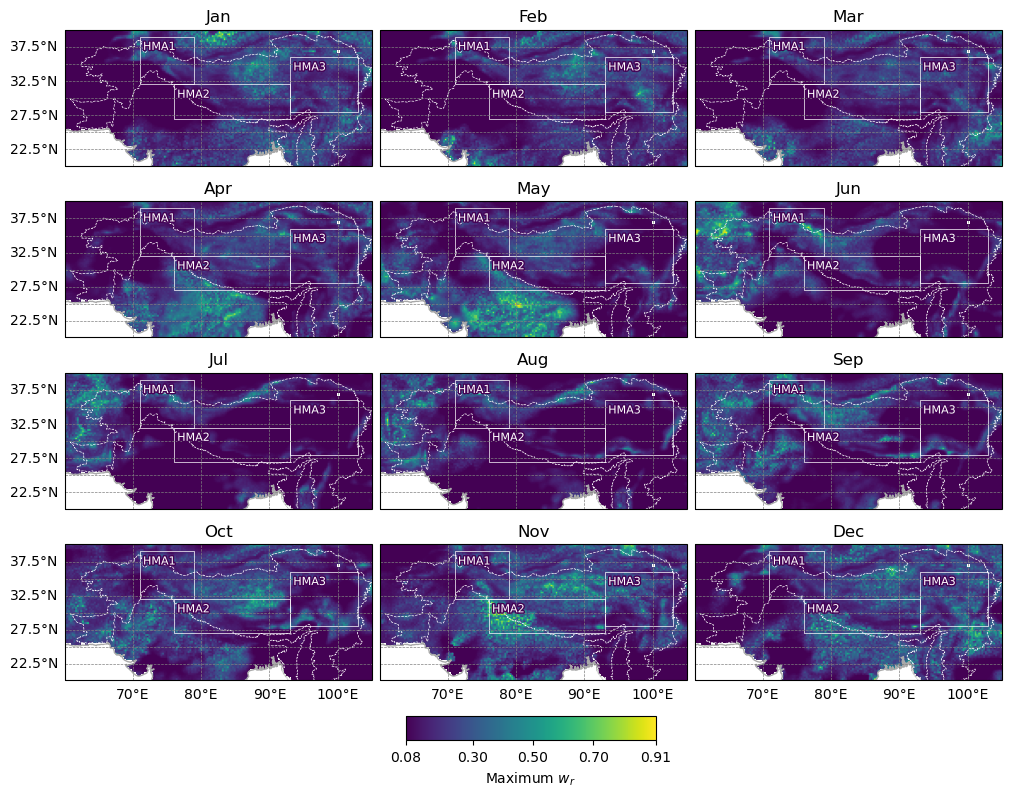

In [31]:
# For each month, plot make a plot where the color of each lat lon is the rcm with the smallest wass distance

fig, ax = plt.subplots(4, 3, figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()}, layout="constrained")

ocean_50m = cf.NaturalEarthFeature(
        "physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

for i in range(12):
    g = ax[i//3, i%3].imshow(max_w_arr[i].T, cmap='viridis', vmin=cbar_min, vmax=cbar_max, transform=proj, origin='lower', zorder=-10,
                              extent=[60.125, 105, 20.125, 40,])
    ax[i//3, i%3].set_title(months[i])
    gl = ax[i//3, i%3].gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False
    if i % 3 != 0:
       gl.left_labels = False
    if i // 3 != 3:
        gl.bottom_labels = False
    ax[i//3, i%3].add_feature(ocean_50m, zorder=-9)
    ax[i//3, i%3].add_geometries([hma1, hma2, hma3], proj, edgecolor="white",
            facecolor="None", linestyle='-', linewidth=0.5)
    for region, coord in region_dict2.items():
        ax[i//3, i%3].text(coord[0], coord[1], region, fontsize=8, color='white', ha='left', va='center', zorder=10,
            path_effects=[pe.withStroke(linewidth=2, foreground="#440154")])
        # HKH boundaries
    for rec in hkh_region_shape.records():
        ax[i//3, i%3].add_geometries(
            [rec.geometry],
            hkh_region,
            edgecolor="white",
            facecolor="None",
            linestyle='--',
            linewidth=0.5,
            zorder=-8)
        
# rasterize negative zorder
for ax in fig.axes:
    ax.set_rasterization_zorder(0)

cax = fig.add_axes([0.4, -0.05, 0.25, 0.035])
cb = fig.colorbar(g, cax=cax, orientation='horizontal', label='Maximum $w_r$', 
                  extend='neither', ticks=[cbar_min, 0.3, 0.5, 0.7, cbar_max],
                  format='%.2f')
plt.savefig('max_weight.pdf', dpi=300, bbox_inches='tight')